# 目的：使用第三方的代码，看是否可以收敛
https://ypw.io/captcha/

todo：结论，是否能跑？

In [0]:
# !pip install captcha
# !pip install tqdm
# # !kill -9 -1
# !cat /proc/meminfo

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5,1,u'WXX7')

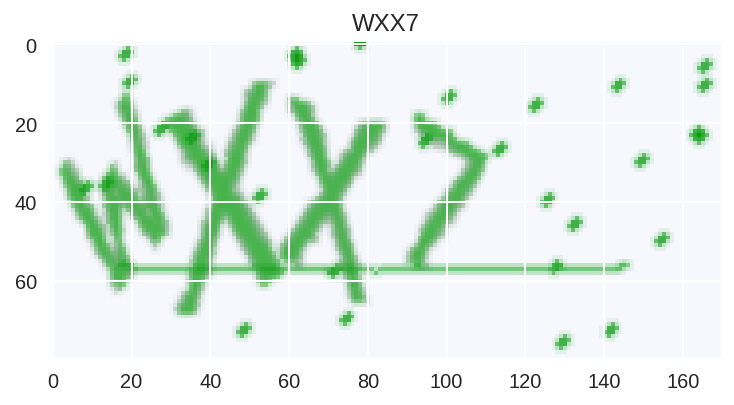

In [3]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

In [0]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

Text(0.5,1,u'4GFC')

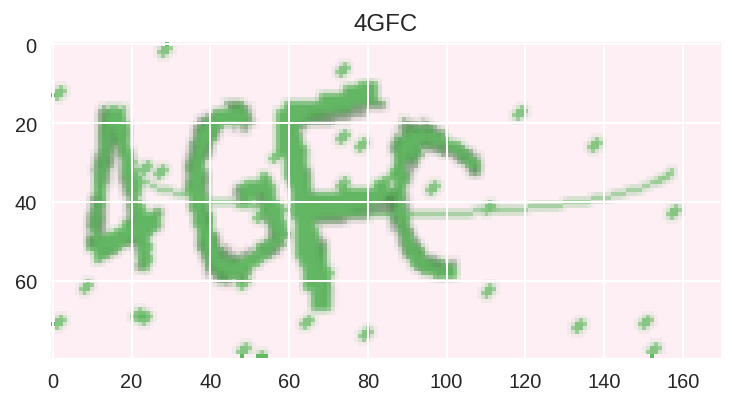

In [5]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [6]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Ker

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 76, 166, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 38, 83, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [8]:
model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5, 
                    nb_worker=2, pickle_safe=True, 
                    validation_data=gen(), nb_val_samples=1280)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., use_multiprocessing=True, workers=2, validation_data=<generator..., steps_per_epoch=51200, epochs=5, validation_steps=1280)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:2087: UserWarn

Epoch 1/5
  444/51200 [..............................] - ETA: 1:41:36 - loss: 14.5406 - c1_loss: 3.6368 - c2_loss: 3.6376 - c3_loss: 3.6383 - c4_loss: 3.6279 - c1_acc: 0.0274 - c2_acc: 0.0260 - c3_acc: 0.0280 - c4_acc: 0.0292

  908/51200 [..............................] - ETA: 1:36:37 - loss: 14.4363 - c1_loss: 3.6099 - c2_loss: 3.6104 - c3_loss: 3.6105 - c4_loss: 3.6056 - c1_acc: 0.0274 - c2_acc: 0.0263 - c3_acc: 0.0284 - c4_acc: 0.0288

 1372/51200 [..............................] - ETA: 1:34:19 - loss: 14.4020 - c1_loss: 3.6010 - c2_loss: 3.6013 - c3_loss: 3.6014 - c4_loss: 3.5983 - c1_acc: 0.0283 - c2_acc: 0.0263 - c3_acc: 0.0285 - c4_acc: 0.0278

 1836/51200 [>.............................] - ETA: 1:32:39 - loss: 14.3851 - c1_loss: 3.5966 - c2_loss: 3.5969 - c3_loss: 3.5970 - c4_loss: 3.5946 - c1_acc: 0.0283 - c2_acc: 0.0269 - c3_acc: 0.0285 - c4_acc: 0.0277

 2300/51200 [>.............................] - ETA: 1:31:30 - loss: 14.3750 - c1_loss: 3.5941 - c2_loss: 3.5942 - c3_loss: 3.5944 - c4_loss: 3.5924 - c1_acc: 0.0278 - c2_acc: 0.0275 - c3_acc: 0.0288 - c4_acc: 0.0275

 2764/51200 [>.............................] - ETA: 1:30:27 - loss: 14.3683 - c1_loss: 3.5923 - c2_loss: 3.5925 - c3_loss: 3.5925 - c4_loss: 3.5909 - c1_acc: 0.0281 - c2_acc: 0.0279 - c3_acc: 0.0289 - c4_acc: 0.0278

 3226/51200 [>.............................] - ETA: 1:29:21 - loss: 14.3636 - c1_loss: 3.5911 - c2_loss: 3.5913 - c3_loss: 3.5913 - c4_loss: 3.5899 - c1_acc: 0.0279 - c2_acc: 0.0281 - c3_acc: 0.0288 - c4_acc: 0.0275

 3690/51200 [=>............................] - ETA: 1:28:22 - loss: 14.3600 - c1_loss: 3.5902 - c2_loss: 3.5903 - c3_loss: 3.5904 - c4_loss: 3.5891 - c1_acc: 0.0279 - c2_acc: 0.0282 - c3_acc: 0.0286 - c4_acc: 0.0276

 4154/51200 [=>............................] - ETA: 1:27:24 - loss: 14.3572 - c1_loss: 3.5895 - c2_loss: 3.5896 - c3_loss: 3.5896 - c4_loss: 3.5885 - c1_acc: 0.0279 - c2_acc: 0.0279 - c3_acc: 0.0285 - c4_acc: 0.0274

 4618/51200 [=>............................] - ETA: 1:26:25 - loss: 14.3550 - c1_loss: 3.5889 - c2_loss: 3.5890 - c3_loss: 3.5891 - c4_loss: 3.5880 - c1_acc: 0.0277 - c2_acc: 0.0281 - c3_acc: 0.0284 - c4_acc: 0.0275

 5081/51200 [=>............................] - ETA: 1:25:46 - loss: 14.3533 - c1_loss: 3.5884 - c2_loss: 3.5886 - c3_loss: 3.5886 - c4_loss: 3.5877 - c1_acc: 0.0276 - c2_acc: 0.0280 - c3_acc: 0.0284 - c4_acc: 0.0275

 5545/51200 [==>...........................] - ETA: 1:24:52 - loss: 14.3518 - c1_loss: 3.5881 - c2_loss: 3.5882 - c3_loss: 3.5882 - c4_loss: 3.5874 - c1_acc: 0.0275 - c2_acc: 0.0280 - c3_acc: 0.0282 - c4_acc: 0.0274

 6009/51200 [==>...........................] - ETA: 1:24:00 - loss: 14.3505 - c1_loss: 3.5877 - c2_loss: 3.5878 - c3_loss: 3.5878 - c4_loss: 3.5871 - c1_acc: 0.0276 - c2_acc: 0.0281 - c3_acc: 0.0284 - c4_acc: 0.0275

 6473/51200 [==>...........................] - ETA: 1:23:09 - loss: 14.3494 - c1_loss: 3.5875 - c2_loss: 3.5875 - c3_loss: 3.5876 - c4_loss: 3.5869 - c1_acc: 0.0275 - c2_acc: 0.0281 - c3_acc: 0.0283 - c4_acc: 0.0276

 6937/51200 [===>..........................] - ETA: 1:22:15 - loss: 14.3485 - c1_loss: 3.5872 - c2_loss: 3.5873 - c3_loss: 3.5873 - c4_loss: 3.5867 - c1_acc: 0.0275 - c2_acc: 0.0281 - c3_acc: 0.0281 - c4_acc: 0.0277

 7399/51200 [===>..........................] - ETA: 1:21:25 - loss: 14.3476 - c1_loss: 3.5870 - c2_loss: 3.5870 - c3_loss: 3.5871 - c4_loss: 3.5865 - c1_acc: 0.0274 - c2_acc: 0.0282 - c3_acc: 0.0279 - c4_acc: 0.0277

 7863/51200 [===>..........................] - ETA: 1:20:34 - loss: 14.3468 - c1_loss: 3.5868 - c2_loss: 3.5868 - c3_loss: 3.5869 - c4_loss: 3.5863 - c1_acc: 0.0276 - c2_acc: 0.0282 - c3_acc: 0.0282 - c4_acc: 0.0278

 8327/51200 [===>..........................] - ETA: 1:19:40 - loss: 14.3462 - c1_loss: 3.5866 - c2_loss: 3.5867 - c3_loss: 3.5867 - c4_loss: 3.5862 - c1_acc: 0.0276 - c2_acc: 0.0283 - c3_acc: 0.0282 - c4_acc: 0.0278

 8791/51200 [====>.........................] - ETA: 1:18:49 - loss: 14.3456 - c1_loss: 3.5865 - c2_loss: 3.5865 - c3_loss: 3.5866 - c4_loss: 3.5861 - c1_acc: 0.0276 - c2_acc: 0.0284 - c3_acc: 0.0282 - c4_acc: 0.0276

 9255/51200 [====>.........................] - ETA: 1:17:59 - loss: 14.3451 - c1_loss: 3.5864 - c2_loss: 3.5864 - c3_loss: 3.5864 - c4_loss: 3.5859 - c1_acc: 0.0275 - c2_acc: 0.0283 - c3_acc: 0.0281 - c4_acc: 0.0276

 9719/51200 [====>.........................] - ETA: 1:17:08 - loss: 14.3446 - c1_loss: 3.5862 - c2_loss: 3.5862 - c3_loss: 3.5863 - c4_loss: 3.5859 - c1_acc: 0.0275 - c2_acc: 0.0283 - c3_acc: 0.0281 - c4_acc: 0.0276

10183/51200 [====>.........................] - ETA: 1:16:15 - loss: 14.3442 - c1_loss: 3.5861 - c2_loss: 3.5861 - c3_loss: 3.5862 - c4_loss: 3.5858 - c1_acc: 0.0275 - c2_acc: 0.0284 - c3_acc: 0.0281 - c4_acc: 0.0276

10647/51200 [=====>........................] - ETA: 1:15:23 - loss: 14.3438 - c1_loss: 3.5860 - c2_loss: 3.5860 - c3_loss: 3.5861 - c4_loss: 3.5857 - c1_acc: 0.0275 - c2_acc: 0.0283 - c3_acc: 0.0281 - c4_acc: 0.0275

11110/51200 [=====>........................] - ETA: 1:14:32 - loss: 14.3435 - c1_loss: 3.5859 - c2_loss: 3.5859 - c3_loss: 3.5860 - c4_loss: 3.5856 - c1_acc: 0.0274 - c2_acc: 0.0283 - c3_acc: 0.0280 - c4_acc: 0.0274

11574/51200 [=====>........................] - ETA: 1:13:40 - loss: 14.3431 - c1_loss: 3.5858 - c2_loss: 3.5859 - c3_loss: 3.5859 - c4_loss: 3.5855 - c1_acc: 0.0275 - c2_acc: 0.0283 - c3_acc: 0.0281 - c4_acc: 0.0274

12038/51200 [======>.......................] - ETA: 1:12:47 - loss: 14.3428 - c1_loss: 3.5858 - c2_loss: 3.5858 - c3_loss: 3.5858 - c4_loss: 3.5855 - c1_acc: 0.0275 - c2_acc: 0.0282 - c3_acc: 0.0281 - c4_acc: 0.0274

12500/51200 [======>.......................] - ETA: 1:11:54 - loss: 14.3425 - c1_loss: 3.5857 - c2_loss: 3.5857 - c3_loss: 3.5857 - c4_loss: 3.5854 - c1_acc: 0.0275 - c2_acc: 0.0282 - c3_acc: 0.0282 - c4_acc: 0.0274

12964/51200 [======>.......................] - ETA: 1:11:01 - loss: 14.3422 - c1_loss: 3.5856 - c2_loss: 3.5856 - c3_loss: 3.5857 - c4_loss: 3.5853 - c1_acc: 0.0275 - c2_acc: 0.0281 - c3_acc: 0.0282 - c4_acc: 0.0274

13428/51200 [======>.......................] - ETA: 1:10:10 - loss: 14.3420 - c1_loss: 3.5855 - c2_loss: 3.5856 - c3_loss: 3.5856 - c4_loss: 3.5853 - c1_acc: 0.0274 - c2_acc: 0.0281 - c3_acc: 0.0281 - c4_acc: 0.0274

13531/51200 [======>.......................] - ETA: 1:09:59 - loss: 14.3420 - c1_loss: 3.5855 - c2_loss: 3.5856 - c3_loss: 3.5856 - c4_loss: 3.5853 - c1_acc: 0.0274 - c2_acc: 0.0281 - c3_acc: 0.0281 - c4_acc: 0.0274

Process Process-3:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-4-1bab083deb05>", line 8, in gen
    X[i] = generator.generate_image(random_str)
  File "/usr/local/lib/python2.7/dist-packages/captcha/image.py", line 226, in generate_image
Process Process-2:


KeyboardInterrupt: ignored

In [0]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')

In [0]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc += np.mean(map(np.array_equal, y_true, y_pred))
    return batch_acc / batch_num

evaluate(model)